In [13]:
import gymnasium as gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [255]:
class UAV_Environment(gym.Env):

    def __init__(self, users = 150, uavs = 3, size = 2000, v_0 = 5,
                ###################### Channel model of UAVS
                psi_L = 1,
                psi_M = 1,
                K = 50, ####
                d = 1,
                lambda_c = 1, ####
                h = 120, ####
                alpha = 2.7,
                P_UAV = 30,
                sigma_square = 90,  
                ######################## Channel model of mBS
                P_mBS = 46,
                D_hb = 1000,
                f_c = 1,
                sigma_logF = 2,
                ###################### Bandwidth
                W = 1000):


        self.users = users
        self.uavs = uavs
        self.size = size
        self.v_o = v_0
        self.psi_L = psi_L
        self.psi_M = psi_M
        self.K = K
        self.d = d
        self.lambda_c = lambda_c
        self.h = h
        self.alpha = alpha
        self.P_UAV = P_UAV
        self.sigma_square = sigma_square
        self.P_mBS = P_mBS
        self.D_hb = D_hb
        self.f_c = f_c
        self.sigma_logF = sigma_logF
        self.W = W

        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self.uavs_location = np.zeros((2, self.uavs)) + self.size/2
        self.users_location = np.random.uniform(-self.size/2, self.size/2, (2, self.users))
        self.mBS = np.zeros((2,1)) + self.size/2
        
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        # self.observation_space = gym.spaces.Dict(
        #     {
        #         "agent": gym.spaces.Box(-size/2, size/2, shape=(2,uavs), dtype=float),
        #     }
        # )

        self.observation_space = gym.spaces.Box(-self.size/2, self.size/2, shape=(2,uavs), dtype=float),


        # We have 5 actions, corresponding to "right", "up", "left", "down", "remain stationary"
        self.action_space = gym.spaces.Discrete(5)
        # Dictionary maps the abstract actions to the directions
        self._action_to_direction = {
            0: np.array([v_0, 0]),  # right
            1: np.array([0, v_0]),  # up
            2: np.array([-v_0, 0]),  # left
            3: np.array([0, -v_0]),  # down
            4: np.array([0, 0]),  # remain stationary
        }
    def step(self, actions):
        ## UAVs take the actions
        for action,k in zip(actions,range(self.uavs)):
            self.uavs_location[:,k] = self.uavs_location[:,k] + self._action_to_direction[action]

        ## Distance
        d_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                d_UAV[k,n] = np.linalg.norm(self.users_location[:,n] - self.uavs_location[:,k])

        d_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            d_mBS[0,n] = np.linalg.norm(self.users_location[:,n] - self.mBS[:,0])

        ## Signal-to-noise ratio(SNR)
        gamma_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                psi_UAV = math.sqrt(self.K/(1+self.K))*self.psi_L + math.sqrt(1/(1+self.K))*self.psi_M
                theta = -20*math.log10(4*3.14*self.d/self.lambda_c)
                g_UAV = psi_UAV*theta*(math.sqrt(d_UAV[k,n]**2 + self.h**2)/self.d)**(-self.alpha)
                gamma_UAV[k,n] = self.P_UAV*g_UAV/self.sigma_square

        gamma_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            LogF = random.gauss(0, self.sigma_logF)
            L_mBS = 40*(1-0.004*self.D_hb)*math.log10(d_mBS[0,n]) - 18*math.log10(self.D_hb) + 21*math.log10(self.f_c) + 80
            gamma_mBS[0,n] = self.P_mBS - L_mBS - LogF

        ## Data rate
        rate_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                rate_UAV[k,n] = self.W*math.log2(1 + gamma_UAV[k,n])
                    
        rate_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            rate_mBS[0,n] = self.W*math.log2(1 + gamma_mBS[0,n])
            

        connect = np.zeros((self.uavs+1, self.users))
        
        print('UAV data rate: ', rate_UAV,'\n mBS data rate: ' ,rate_mBS)
        rate_UAV_mBS = np.concatenate((rate_UAV, rate_mBS), axis=0) # Shape(4,150) -> 3 UAVs + 1 mBS ; 150 Users
        data_rate_max_index = np.argmax(rate_UAV_mBS, axis=0)
        print(data_rate_max_index)
        for index,user in zip(data_rate_max_index,range(self.users)):
            connect[index,user] = 1

        reward = np.sum(rate_UAV_mBS*connect)
            
        return self.uavs_location, reward

    def plot(self):
        plt.scatter(self.users_location[0,:],self.users_location[1,:], label = 'USER')
        plt.scatter(self.uavs_location[0,:],self.uavs_location[1,:], label = 'UAV')
        plt.scatter(self.mBS[0],self.mBS[1], label = 'mBS')
        plt.xlabel('x(m)')
        plt.ylabel('y(m)')
        plt.title('UAV Environment')
        plt.legend()
        plt.show()

    def reset(self):
        self.uavs_location = np.zeros((2, self.uavs)) + self.size/2
        return self.uavs_location       
            

            
            
            

In [256]:
env = UAV_Environment()

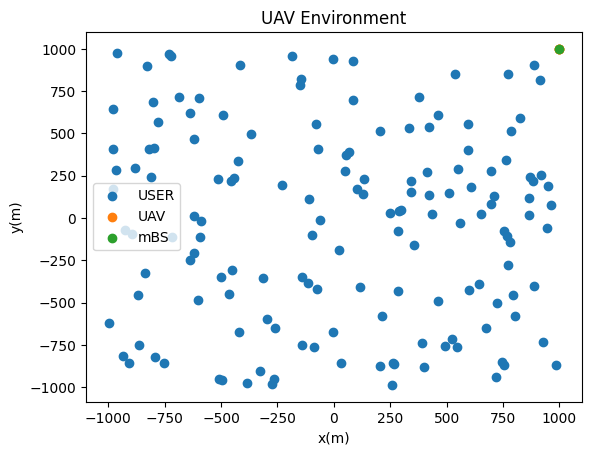

In [257]:
env.plot()

In [258]:
state = env.reset()
for _ in range(100):
    actions = []
    for i in range(4):
        actions.append(env.action_space.sample())
    state, reward = env.step(actions)


UAV data rate:  [[-1.52858176e-05 -1.26433213e-04 -2.43705387e-05 -1.28618132e-05
  -1.51128827e-05 -1.10952695e-04 -2.22735664e-05 -2.37989326e-05
  -5.88487072e-05 -1.11911443e-05 -3.27300937e-05 -9.68546511e-05
  -7.93819953e-05 -3.57280279e-04 -8.29442405e-06 -1.74394508e-05
  -2.03917401e-05 -2.32354486e-05 -2.67674453e-05 -3.32264297e-05
  -1.29149513e-05 -1.84533838e-05 -4.66234338e-05 -2.40610579e-04
  -6.13008785e-05 -5.80414563e-05 -1.20168955e-05 -7.38156457e-06
  -6.79892920e-06 -9.16336767e-05 -1.83843761e-05 -2.14350552e-05
  -7.51201403e-06 -2.94613286e-05 -6.16825166e-04 -1.02330670e-04
  -6.72297260e-06 -1.16974745e-04 -2.13631728e-05 -1.84884444e-05
  -2.99348713e-05 -7.12266467e-05 -2.91388685e-05 -4.94979260e-04
  -2.21491834e-05 -1.14693209e-05 -2.08232264e-04 -3.34964738e-05
  -1.48551019e-04 -1.54102207e-05 -1.97553557e-04 -2.30857052e-05
  -6.28674707e-05 -8.76533287e-06 -1.69781755e-05 -1.87185782e-04
  -6.14502503e-05 -1.28030483e-05 -8.86157057e-05 -1.9853432

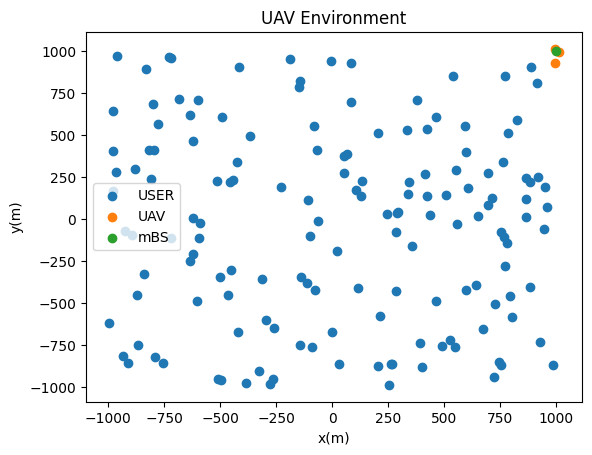

In [259]:
env.plot()